In [34]:
from monai import data, transforms
import os
from monai.data import load_decathlon_datalist
import torch
import math
import numpy as np
from torch.multiprocessing import set_start_method

import warnings

warnings.filterwarnings("ignore", message="TypedStorage is deprecated")


In [35]:
class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, num_replicas=None, rank=None, shuffle=True, make_even=True):
        if num_replicas is None:
            if not torch.distributed.is_available():
                raise RuntimeError("Requires distributed package to be available")
            num_replicas = torch.distributed.get_world_size()
        if rank is None:
            if not torch.distributed.is_available():
                raise RuntimeError("Requires distributed package to be available")
            rank = torch.distributed.get_rank()
        self.shuffle = shuffle
        self.make_even = make_even
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.num_samples = int(math.ceil(len(self.dataset) * 1.0 / self.num_replicas))
        self.total_size = self.num_samples * self.num_replicas
        indices = list(range(len(self.dataset)))
        self.valid_length = len(indices[self.rank : self.total_size : self.num_replicas])

    def __iter__(self):
        if self.shuffle:
            g = torch.Generator()
            g.manual_seed(self.epoch)
            indices = torch.randperm(len(self.dataset), generator=g).tolist()
        else:
            indices = list(range(len(self.dataset)))
        if self.make_even:
            if len(indices) < self.total_size:
                if self.total_size - len(indices) < len(indices):
                    indices += indices[: (self.total_size - len(indices))]
                else:
                    extra_ids = np.random.randint(low=0, high=len(indices), size=self.total_size - len(indices))
                    indices += [indices[ids] for ids in extra_ids]
            assert len(indices) == self.total_size
        indices = indices[self.rank : self.total_size : self.num_replicas]
        self.num_samples = len(indices)
        return iter(indices)

    def __len__(self):
        return self.num_samples

    def set_epoch(self, epoch):
        self.epoch = epoch


In [111]:
from monai import data, transforms
from monai.data import load_decathlon_datalist
from monai.transforms import RandSpatialCropd


# normalized form 
def get_loader():
    data_dir = '/Users/aryanneizehbaz/Aryan8221/coding_projects/SSL-OARs-Tumor-Segmentation-in-PETCT/Dosimetry_Finetune/data'
    datalist_json = os.path.join(data_dir, 'fold0.json')
    
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"], image_only=True),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            RandSpatialCropd(keys=["image", "label"], roi_size=(96, 96, 96), random_size=False),
            transforms.RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=0.2, spatial_axis=2),
            transforms.RandRotate90d(keys=["image", "label"], prob=0.2, max_k=3),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=0.1),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=0.1),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"],image_only=True),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            transforms.CropForegroundd(keys=["image", "label"], source_key="image"),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    test_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"],image_only=True),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            # transforms.Orientationd(keys=["image"], axcodes="RAS"),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )
    
    test_mode = False
    distributed = False
    use_normal_dataset = False
    
    if test_mode:
        test_files = load_decathlon_datalist(datalist_json, True, "validation", base_dir=data_dir)
        test_ds = data.Dataset(data=test_files, transform=test_transform)
        test_sampler = Sampler(test_ds, shuffle=False) if distributed else None
        test_loader = data.DataLoader(
            test_ds,
            batch_size=1,
            shuffle=False,
            num_workers=4,
            sampler=test_sampler,
            pin_memory=False,
            persistent_workers=True,
        )
        loader = test_loader
    else:
        datalist = load_decathlon_datalist(datalist_json, True, "training", base_dir=data_dir)
        if use_normal_dataset:
            train_ds = data.Dataset(data=datalist, transform=train_transform)
        else:
            train_ds = data.CacheDataset(
                data=datalist, transform=train_transform, cache_num=24, cache_rate=1.0, num_workers=4
            )
        train_sampler = Sampler(train_ds) if distributed else None
        train_loader = data.DataLoader(
            train_ds,
            batch_size=1,
            shuffle=(train_sampler is None),
            num_workers=4,
            sampler=train_sampler,
            pin_memory=False,
        )
        val_files = load_decathlon_datalist(datalist_json, True, "validation", base_dir=data_dir)
        val_ds = data.Dataset(data=val_files, transform=val_transform)
        val_sampler = Sampler(val_ds, shuffle=False) if distributed else None
        val_loader = data.DataLoader(
            val_ds, batch_size=1, shuffle=False, num_workers=4, sampler=val_sampler, pin_memory=False
        )
        loader = [train_loader, val_loader]

    return loader


In [62]:
loader = get_loader()

print(len(loader))
train = []
val = []

for i, batch in enumerate(loader[0]):
    train.append(batch)
    
for i, batch in enumerate(loader[1]):
    val.append(batch) 

Loading dataset: 100%|██████████| 11/11 [00:15<00:00,  1.41s/it]

2



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/monai/data/__init__.py:117: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/monai/data/__init__.py:117: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  t = cls([], dtype=storage.dtype, device=storage.device)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/monai/data/__init

In [112]:
train[0]['image']

tensor([[[[[1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           ...,
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01]],

          [[1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           [1.6667e-01, 1.6667e-01, 1.6667e-01,  ..., 1.6667e-01,
            1.6667e-01, 1.6667e-01],
           ...,
           [1.6667e-01, 1.6667e-01, 1.6

In [115]:
torch.unique(train[0]['label'].flatten().sort()[0])

tensor([0.0000e+00, 1.2757e-02, 1.4838e-02,  ..., 4.0169e+01, 4.1068e+01,
        4.5346e+01])

In [55]:
val[0]['image'].shape

torch.Size([1, 2, 156, 156, 290])

In [64]:
# Assume these were the min and max values used during normalization
ct_hu_min, ct_hu_max = -200, 1000
pet_hu_min, pet_hu_max = 0, 100

# Reverse normalization function
def reverse_normalize(data, min_val, max_val):
    return data * (max_val - min_val) + min_val

# Get the first batch
image = train[0]['image']
label = train[0]['label']

# Reverse normalize the image and label
image_original = reverse_normalize(image.numpy(), ct_hu_min, ct_hu_max)
label_original = reverse_normalize(label.numpy(), pet_hu_min, pet_hu_max)

print("Original Image Mean:", image_original.flatten().mean())
print("Original Label Mean:", label_original.flatten().mean())

Original Image Mean: -137.31337
Original Label Mean: 44.245487


In [72]:
len(label_original.flatten())

884736

In [98]:
num_zeros = np.sum(label_original.flatten() < 20)
print("Number of zeros in the label:", num_zeros)

Number of zeros in the label: 526821


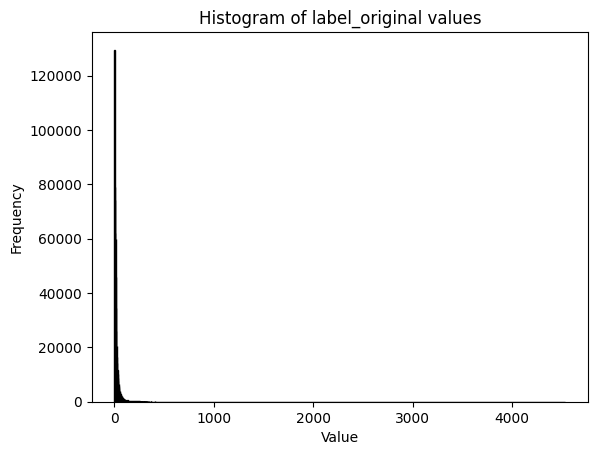

In [78]:
import matplotlib.pyplot as plt

# Flatten the label array
label_flattened = label_original.flatten()

# Draw the histogram
plt.hist(label_flattened, bins=5000, edgecolor='black')
plt.title('Histogram of label_original values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Find unique values and sort them in ascending order
unique_image_values = np.unique(image_original)
unique_label_values = np.unique(label_original)

# Print unique values
print("Unique Image Values (ascending):", unique_image_values)
print("Unique Label Values (ascending):", unique_label_values)

Unique Image Values (ascending): [-200.      -199.96338 -199.92676 ...  998.       999.      1000.     ]
Unique Label Values (ascending): [0.0000000e+00 1.2756839e+00 1.4837977e+00 ... 4.0169412e+03 4.1068296e+03
 4.5346338e+03]


In [110]:
len(unique_label_values)

295933

In [105]:
import numpy as np

y_true = np.array([23, 53, 63, 45, 23, 57, 75, 100, 23, 34])
y_pred = np.array([20, 23, 50, 30, 23, 13, 75, 78, 24, 99])

# Flatten the arrays to ensure element-wise operations
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Filter out zero values in y_true
mask = y_true != 0
y_true = y_true[mask]
y_pred = y_pred[mask]

# Calculate the numerator and denominator
numerator = np.abs(y_true - y_pred)
denominator = np.abs(y_true) + np.abs(y_pred)


# Calculate sMAPE
smape = np.mean(2.0 * numerator / denominator) * 100

print("sMAPE:", smape)


sMAPE: 40.83427732397408


In [106]:
numerator

array([ 3, 30, 13, 15,  0, 44,  0, 22,  1, 65])

In [107]:
denominator

array([ 43,  76, 113,  75,  46,  70, 150, 178,  47, 133])

In [20]:

# Print the affine matrices for the first batch
for i, batch in enumerate(loader):
    for j in range(len(batch["image"])):
        print(f"Batch {i}, Image {j} Affine:\n", batch["image_meta_dict"]["affine"][j])
        print(f"Batch {i}, Label {j} Affine:\n", batch["label_meta_dict"]["affine"][j])
    if i == 0:  # Just print the first batch for brevity
        break

Batch 0, Image 0 Affine:
 tensor([[ -4.0728,   0.0000,   0.0000, 338.8047],
        [  0.0000,  -4.0728,   0.0000, 512.1872],
        [  0.0000,   0.0000,   3.0000, 215.5000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)
Batch 0, Label 0 Affine:
 tensor([[ -4.0728,   0.0000,   0.0000, 338.8047],
        [  0.0000,  -4.0728,   0.0000, 512.1872],
        [  0.0000,   0.0000,   3.0000, 215.5000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)
Batch 0, Image 1 Affine:
 tensor([[ -4.0728,   0.0000,   0.0000, 338.8047],
        [  0.0000,  -4.0728,   0.0000, 512.1872],
        [  0.0000,   0.0000,   3.0000, 215.5000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)
Batch 0, Label 1 Affine:
 tensor([[ -4.0728,   0.0000,   0.0000, 338.8047],
        [  0.0000,  -4.0728,   0.0000, 512.1872],
        [  0.0000,   0.0000,   3.0000, 215.5000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], dtype=torch.float64)
Batch 0,

In [147]:
print(batches[0].keys())

dict_keys(['image', 'label', 'image_meta_dict', 'label_meta_dict', 'foreground_start_coord', 'foreground_end_coord'])


In [119]:
batches[0]['image_meta_dict']

{'sizeof_hdr': tensor([348], dtype=torch.int32),
 'extents': tensor([0], dtype=torch.int32),
 'session_error': tensor([0], dtype=torch.int16),
 'dim_info': tensor([0], dtype=torch.uint8),
 'dim': tensor([[  3, 168, 168, 324,   1,   1,   1,   1]], dtype=torch.int16),
 'intent_p1': tensor([0.]),
 'intent_p2': tensor([0.]),
 'intent_p3': tensor([0.]),
 'intent_code': tensor([0], dtype=torch.int16),
 'datatype': tensor([64], dtype=torch.int16),
 'bitpix': tensor([64], dtype=torch.int16),
 'slice_start': tensor([0], dtype=torch.int16),
 'pixdim': tensor([[1.0000, 4.0728, 4.0728, 3.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
 'vox_offset': tensor([0.]),
 'scl_slope': tensor([nan]),
 'scl_inter': tensor([nan]),
 'slice_end': tensor([0], dtype=torch.int16),
 'slice_code': tensor([0], dtype=torch.uint8),
 'xyzt_units': tensor([2], dtype=torch.uint8),
 'cal_max': tensor([0.]),
 'cal_min': tensor([0.]),
 'slice_duration': tensor([0.]),
 'toffset': tensor([0.]),
 'glmax': tensor([0], dtype=torch.int3

In [108]:
for i, batch in enumerate(loader[1]):
    print(f"Batch {i+1}:")
    for key in batch.keys():
        print(f"Key: {key}")
        if isinstance(batch[key], dict):
            for meta_key in batch[key].keys():
                print(f"  Meta Key: {meta_key}")
                if isinstance(batch[key][meta_key], dict):
                    for sub_meta_key in batch[key][meta_key].keys():
                        print(f"    Sub Meta Key: {sub_meta_key}")
    break  # Only process the first batch for demonstration

Batch 1:
Key: image
Key: label
Key: foreground_start_coord
Key: foreground_end_coord


Training datalist length: 11
Validation datalist length: 3
Training dataset length: 11
Validation dataset length: 3
Length of training loader: 6
Length of validation loader: 3


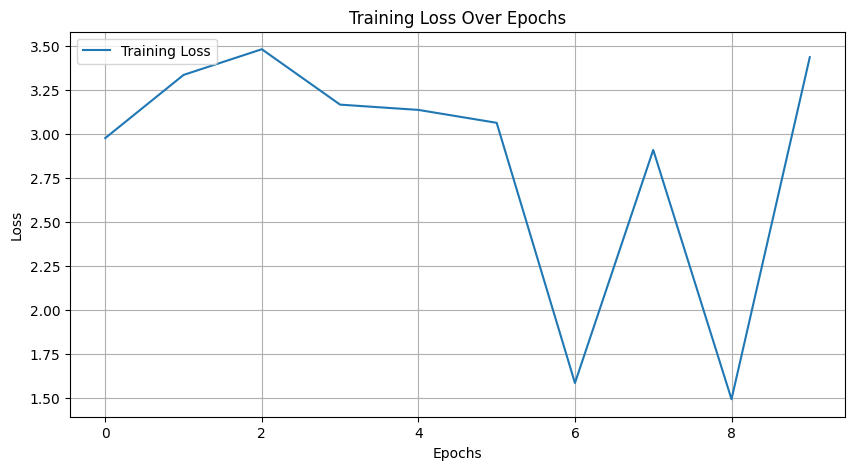

In [33]:
def extract_losses(log_file_path):
    loss_pattern = re.compile(r'Final training\s+\d+/\d+\s+loss:\s+([0-9]+\.[0-9]+)')
    losses = []
    
    with open(log_file_path, 'r') as file:
        for line in file:
            match = loss_pattern.search(line)
            if match:
                losses.append(float(match.group(1)))
    
    return losses

def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

log_file_path = "/Users/aryanneizehbaz/Aryan8221/coding_projects/SSL-OARs-Tumor-Segmentation-in-PETCT/Dosimetry_Finetune/runs/logFile_2024-06-06_21:20.log"

losses = extract_losses(log_file_path)

plot_losses(losses)


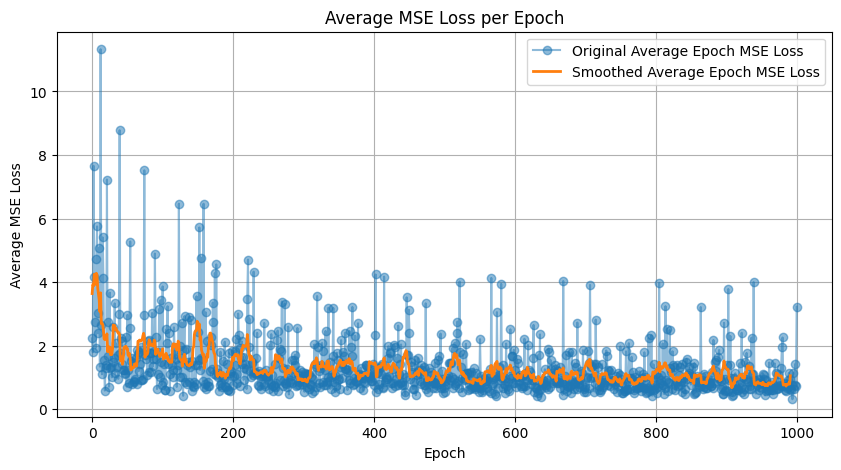

In [120]:
import re
import matplotlib.pyplot as plt
import numpy as np

def extract_epoch_mse_losses(log_file_path):
    epoch_pattern = re.compile(r'Epoch (\d+)/\d+ \d+/\d+\s+loss:\s*([0-9]+\.[0-9]+)')
    epoch_losses = {}
    
    with open(log_file_path, 'r') as file:
        for line in file:
            match = epoch_pattern.search(line)
            if match:
                epoch = int(match.group(1))
                loss = float(match.group(2))
                if epoch not in epoch_losses:
                    epoch_losses[epoch] = []
                epoch_losses[epoch].append(loss)
    
    avg_epoch_losses = [sum(losses) / len(losses) for epoch, losses in sorted(epoch_losses.items())]
    
    return avg_epoch_losses

def smooth_losses(losses, window_size=10):
    return np.convolve(losses, np.ones(window_size)/window_size, mode='valid')

def plot_avg_epoch_mse_losses(avg_epoch_losses, smoothed_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(avg_epoch_losses, marker='o', linestyle='-', alpha=0.5, label="Original Average Epoch MSE Loss")
    plt.plot(smoothed_losses, marker='', linestyle='-', label="Smoothed Average Epoch MSE Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Average MSE Loss")
    plt.title("Average MSE Loss per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

log_file_path = "/Users/aryanneizehbaz/Aryan8221/coding_projects/SSL-OARs-Tumor-Segmentation-in-PETCT/Dosimetry_Finetune/runs/pet-fold0.log"

avg_epoch_losses = extract_epoch_mse_losses(log_file_path)

smoothed_losses = smooth_losses(avg_epoch_losses, window_size=10)

plot_avg_epoch_mse_losses(avg_epoch_losses, smoothed_losses)
